In [ ]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

import os
import sys

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

2025-03-13 20:28:59.208613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 20:28:59.219307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 20:28:59.335800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 20:28:59.450223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741877939.534424   16954 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741877939.56

## Loading Data

In [ ]:
data_csv_path = '/home/smrutibiswal/Research/Dataset/labels/edited'
df_t = pd.read_csv(os.path.join(data_csv_path, 'Detailed_PHQ8_Labels.csv'))
df_t.head()

,Participant_ID,PHQ_8NoInterest,PHQ_8Depressed,PHQ_8Sleep,PHQ_8Tired,PHQ_8Appetite,PHQ_8Failure,PHQ_8Concentrating,PHQ_8Moving,PHQ_8Total
0,300,0,0,1,0,1,0,0,0,2
1,301,0,0,1,1,1,0,0,0,3
2,302,1,1,0,1,0,1,0,0,4
3,303,0,0,0,0,0,0,0,0,0
4,304,0,1,1,2,2,0,0,0,6


In [ ]:
# only keep ParticipantID and PHQ_8Total columns
df_t = df_t[['Participant_ID', 'PHQ_8Total']]
df_t.head()


,Participant_ID,PHQ_8Total
0,300,2
1,301,3
2,302,4
3,303,0
4,304,6


The above csv doesn't have the binary target coulmns. So we take train and test df and merge it to get the entire df.

In [ ]:
train_df = pd.read_csv(os.path.join(data_csv_path, 'train_split.csv'))
train_df = train_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]
train_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score
0,302,male,0,4
1,303,female,0,0
2,304,female,0,6
3,305,male,0,7
4,307,female,0,4


In [ ]:
test_df = pd.read_csv(os.path.join(data_csv_path, 'dev_split.csv'))
test_df = test_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]
test_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score
0,300,male,0,2
1,301,male,0,3
2,306,female,0,0
3,317,male,0,8
4,320,female,0,11


In [ ]:
# merging train_df and test_df
df = pd.concat([train_df, test_df], axis=0)

# sorting by Participant_ID
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)

df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score
0,300,male,0,2
1,301,male,0,3
2,302,male,0,4
3,303,female,0,0
4,304,female,0,6


In [ ]:
df.describe()

,Participant_ID,PHQ_Binary,PHQ_Score
count,196.000000,196.000000,196.000000
mean,403.724490,0.219388,6.617347
std,68.420162,0.414892,5.901022
min,300.000000,0.000000,0.000000
25%,349.750000,0.000000,2.000000
50%,400.500000,0.000000,5.000000
75%,449.250000,0.000000,10.000000
max,628.000000,1.000000,23.000000


In [ ]:
df.groupby('PHQ_Binary').describe().T

PHQ_Binary                     0           1
Participant_ID count  153.000000   43.000000
               mean   410.895425  378.209302
               std     70.111862   55.594860
               min    300.000000  308.000000
               25%    358.000000  345.500000
               50%    413.000000  365.000000
               75%    458.000000  407.500000
               max    628.000000  617.000000
PHQ_Score      count  153.000000   43.000000
               mean     4.156863   15.372093
               std      3.654697    3.579194
               min      0.000000   10.000000
               25%      1.000000   12.000000
               50%      3.000000   15.000000
               75%      7.000000   18.000000
               max     16.000000   23.000000

In [ ]:
# only use counts of PHQ_Binary
df['PHQ_Binary'].value_counts()

PHQ_Binary
0    153
1     43
Name: count, dtype: int64

In df, there should be a coulmn for the text of the transcript.

Now we can use
1. entire text, converted to single sentence
2. vectorized text using tfidf or word2vec

## Visualizing Data

In [ ]:
import csv

In [ ]:
def detect_separator(file_path):
    """
    Detects the separator used in a CSV file.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        str: The detected separator, or None if it cannot be determined.
    """
    with open(file_path, 'r', encoding='utf-8') as csvfile:
        sniffer = csv.Sniffer()
        try:
            sample = csvfile.read(1024)
            dialect = sniffer.sniff(sample)
            return dialect.delimiter
        except csv.Error:
            return None

In [ ]:
# convert all csv to txt

train_path = '/home/smrutibiswal/Research/Dataset/data/train/transcripts'
test_path = '/home/smrutibiswal/Research/Dataset/data/validation/transcripts'

# number of files in train and test
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

print(f'Number of files in train: {len(train_files)}')
print(f'Number of files in test: {len(test_files)}')

train_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/train'
test_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

if not os.path.exists(train_conv_txt_path):
    os.makedirs(train_conv_txt_path)
    
if not os.path.exists(test_conv_txt_path):
    os.makedirs(test_conv_txt_path)

Number of files in train: 148
Number of files in test: 48


In [ ]:
train_file = os.path.join(train_path, '363_TRANSCRIPT.csv')
separator = detect_separator(train_file)

text = []

tran = pd.read_csv(train_file)
for i in range(len(tran)):
    text.append(tran['Text'][i])
    
text = ' '.join(text)
    
print(text)
# write to txt file
with open(os.path.join(train_conv_txt_path, '363.txt'), 'w') as f:
    f.write(text)
    
train_file = os.path.join(train_path, '444_TRANSCRIPT.csv')
separator = detect_separator(train_file)

text = []

tran = pd.read_csv(train_file, sep='\t')
tran.head()
for i in range(len(tran)):
    if getattr(tran, 'speaker')[i] == 'Participant':
        text.append(getattr(tran, 'value')[i])                

text = ' '.join(text)
    
print(text)
# write to txt file
with open(os.path.join(train_conv_txt_path, '444.txt'), 'w') as f:
    f.write(text)

okay great so everything's all set up now okay  okay  sorry about that.  want to give me one second I'll be right back okay  that's okay  user  we have this  yeah course  so that's all right so just keep going so I'm going to  something for our purposes after I start  kind of spooky  okay  hi I'm Ali  created to talk to people in the states  and please  are you okay with this yes  good how are you  I am from Los Angeles  yes  it's the center of everything that you can get to all the places you need to go to without having to drive very far I like being in the city  well meaning la also you're dealing with traffic a lot of congestion and obviously the environment as far as the air quality is not that great but you know you live with that  why was a business administration major so I studied business and after I finish college I am pursued a career in retail operations  are you still doing that I know as a matter of fact I am not a kind of changed career over the last four or five years 

In [ ]:
count = 0
for file in os.listdir(train_path):
    if file.endswith('.csv'):
        count += 1
        # check separator
        separator = detect_separator(os.path.join(train_path, file))
        text = []
            
        if separator == '\t':
            tran = pd.read_csv(os.path.join(train_path, file), sep='\t')
            
            for i in range(len(tran)):
                if getattr(tran, 'speaker')[i] == 'Participant':
                    text.append(getattr(tran, 'value')[i])                
            text = ' '.join(text)
            
        else:
            tran = pd.read_csv(os.path.join(train_path, file))
            # print(len(tran.columns), separator)
            for i in range(len(tran)):
                text.append(tran['Text'][i])
                
            text = ' '.join(text)
            
        # write to txt file remove transcript from file name
        
        with open(os.path.join(train_conv_txt_path, file.replace('_TRANSCRIPT.csv', '.txt')), 'w') as f:
            f.write(text)
        # with open(os.path.join(train_conv_txt_path, file.replace('.csv', '.txt')), 'w') as f:
        #     f.write(text)
            
count_conv = 0
for file in os.listdir(train_conv_txt_path):
    if file.endswith('.txt'):
        count_conv += 1
        
if count == count_conv:
    print('All files converted successfully')
else:
    print(count, count_conv)
    
    
file_nams = []
for file in os.listdir(train_conv_txt_path):
    if file.endswith('.txt'):
        # without extension
        file_nams.append(file.split('.')[0])
    
# sort file names
file_nams = sorted(file_nams)

namess_pre = []

for file in os.listdir(train_path):
    if file.endswith('.csv'):
        name = file.split('_TRANSCRIPT.csv')[0]
        namess_pre.append(name)
        
namess_pre = sorted(namess_pre)

for i in range(len(namess_pre)):
    if namess_pre[i] != file_nams[i]:
        print(namess_pre[i], file_nams[i])

All files converted successfully


In [ ]:
count_test = 0
for file in os.listdir(test_path):
    if file.endswith('.csv'):
        count_test += 1

        # check separator
        separator = detect_separator(os.path.join(test_path, file))
        text = []
            
        if separator == '\t':
            tran = pd.read_csv(os.path.join(test_path, file), sep='\t')
            for i in range(len(tran)):
                if getattr(tran, 'speaker')[i] == 'Participant':
                    # check if value is nan
                    if pd.isnull(getattr(tran, 'value')[i]):
                        continue
                    text.append(getattr(tran, 'value')[i])                
        else:
            tran = pd.read_csv(os.path.join(test_path, file))
            for i in range(len(tran)):
                text.append(tran['Text'][i])
                
        text = ' '.join(text)
        # write to txt file
        with open(os.path.join(test_conv_txt_path, file.replace('_TRANSCRIPT.csv', '.txt')), 'w') as f:
            f.write(text)
            
count_conv_test = 0
for file in os.listdir(test_conv_txt_path):
    if file.endswith('.txt'):
        count_conv_test += 1
        
if count_test == count_conv_test:
    print('All files converted successfully')
else:
    print(count_test, count_conv)

test_names = []
conv_test_names = []

for file in os.listdir(test_conv_txt_path):
    if file.endswith('.txt'):
        conv_test_names.append(file.split('.')[0])
        
conv_test_names = sorted(conv_test_names)

for file in os.listdir(test_path):
    if file.endswith('.csv'):
        name = file.split('_TRANSCRIPT.csv')[0]
        test_names.append(name)

test_names = sorted(test_names)

for i in range(len(test_names)):
    if test_names[i] != conv_test_names[i]:
        print(test_names[i], conv_test_names[i])
    

All files converted successfully


In [ ]:
# add another blank column for the text
df['Text'] = ''

train_df['Text'] = ''
train_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/train'

for i in range(len(train_df)):
    file_name = str(train_df['Participant_ID'][i]) + '.txt'
    with open(os.path.join(train_conv_txt_path, file_name), 'r') as f:
        text = f.read()
        train_df['Text'][i] = text
        
train_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Text
0,302,male,0,4,just move around a little bit when you're fin...
1,303,female,0,0,wow okay when you're finished when she's done...
2,304,female,0,6,so we'll just move around a little bit tonight...
3,305,male,0,7,okay looks good so we can just move around a l...
4,307,female,0,4,looking at you all right okay so now let's mak...


In [ ]:
test_df['Text'] = ''
test_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

print(len(test_df))
print(count_test)

for i in range(len(test_df)):
    file_name = str(test_df['Participant_ID'][i]) + '.txt'
    with open(os.path.join(test_conv_txt_path, file_name), 'r') as f:
        text = f.read()
        test_df['Text'][i] = text
        
test_df.head()

48
48


,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Text
0,300,male,0,2,so I'm going to interview in Spanish okay g...
1,301,male,0,3,yeah there's also on Craigslist so that's why ...
2,306,female,0,0,okay looks like we're good. Let's move around ...
3,317,male,0,8,equipment okay how was okay thanks are you ...
4,320,female,0,11,perfect okay and okay and then I will let you...


In [ ]:
# merging train_df and test_df
df = pd.concat([train_df, test_df], axis=0)

# sorting by Participant_ID
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)

df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Text
0,300,male,0,2,so I'm going to interview in Spanish okay g...
1,301,male,0,3,yeah there's also on Craigslist so that's why ...
2,302,male,0,4,just move around a little bit when you're fin...
3,303,female,0,0,wow okay when you're finished when she's done...
4,304,female,0,6,so we'll just move around a little bit tonight...


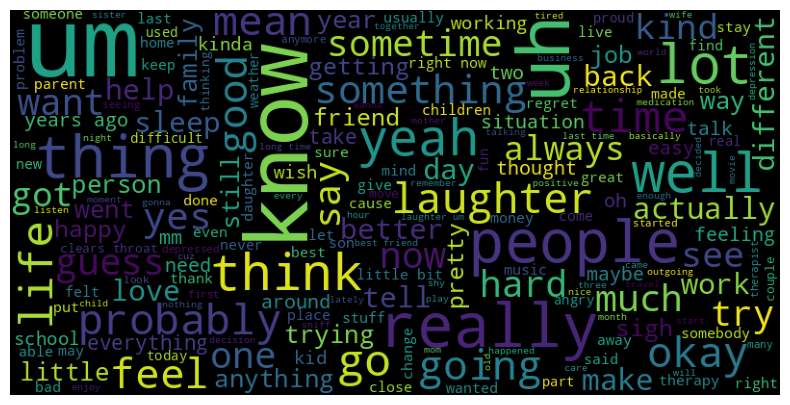

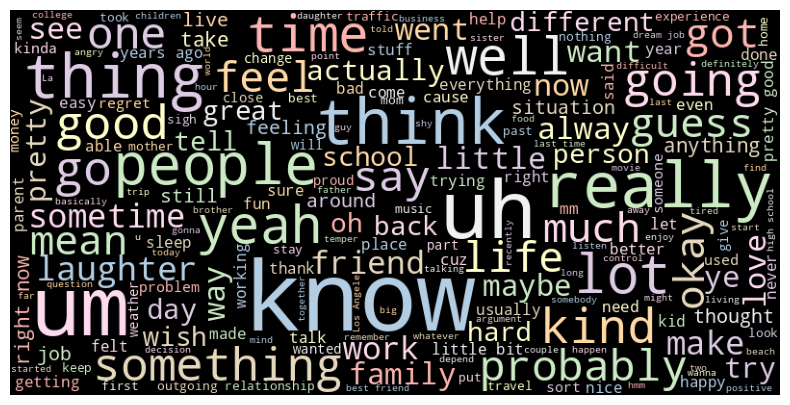

In [ ]:
depressed_wordcloud = wordcloud.WordCloud(width=800, height=400, background_color ='black', stopwords=STOPWORDS, max_font_size=100).generate(' '.join(df[df['PHQ_Binary'] == 1]['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(depressed_wordcloud)
plt.axis('off')
plt.show()

not_depressed_wordcloud = wordcloud.WordCloud(width=800, height=400, background_color ='black', stopwords=STOPWORDS,max_font_size=100, colormap='Pastel1').generate(' '.join(df[df['PHQ_Binary'] == 0]['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(not_depressed_wordcloud)
plt.axis('off')
plt.show()


## Data Imbalance

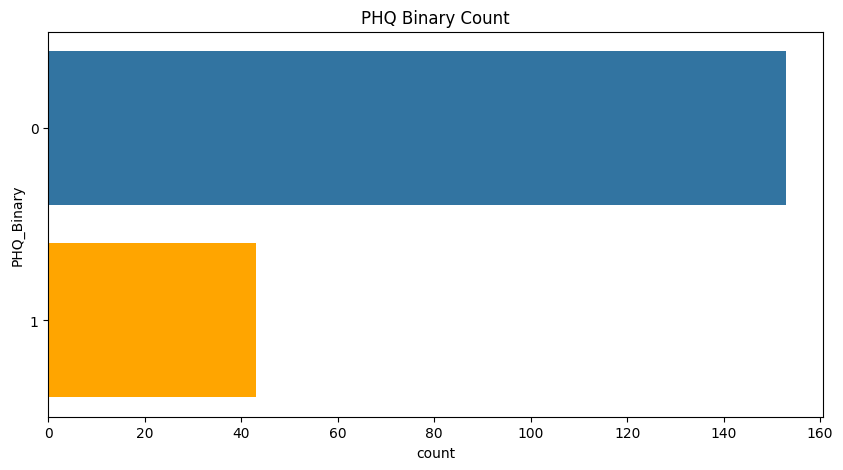

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()

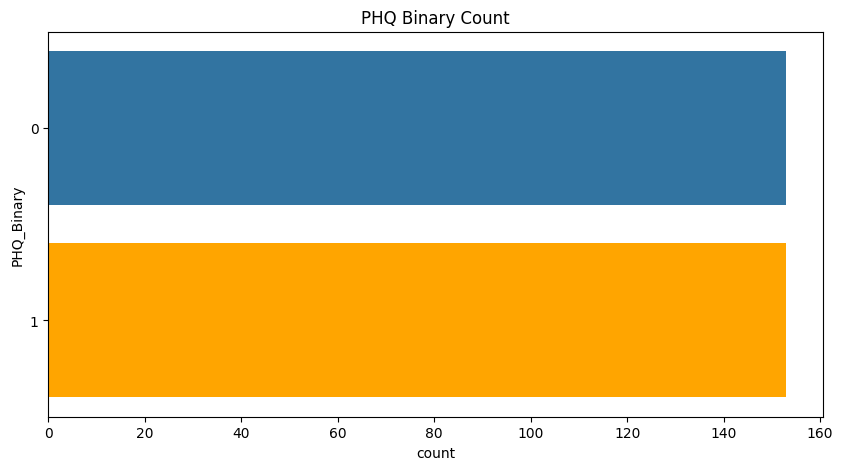

In [ ]:
depressed = df[df['PHQ_Binary'] == 1]
not_depressed = df[df['PHQ_Binary'] == 0]

# not_depressed = not_depressed.sample(n=len(depressed), random_state=44)
depressed = depressed.sample(n=len(not_depressed), random_state=44, replace=True)

df = pd.concat([depressed, not_depressed], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=44).reset_index(drop=True)

plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()


In [ ]:
df.to_csv('new.csv', index=False)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Text
0,351,female,1,14,yes <clears throat> okay um new york um to pur...
1,455,female,0,1,<synch> yes very well uh ohio mhm uh finished ...
2,411,female,0,0,I was just wondering if she doesn't look like ...
3,389,male,1,14,and please are you okay sure I'm okay smal...
4,454,female,0,1,<synch> yes great and yourself houston texas w...


In [ ]:
# sort by Participant_ID
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)

df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Text
0,300,male,0,2,so I'm going to interview in Spanish okay g...
1,301,male,0,3,yeah there's also on Craigslist so that's why ...
2,302,male,0,4,just move around a little bit when you're fin...
3,303,female,0,0,wow okay when you're finished when she's done...
4,304,female,0,6,so we'll just move around a little bit tonight...


## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['PHQ_Binary'], test_size=0.2, random_state=44)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(244,) (62,) (244,) (62,)


## Tokenization

In [ ]:
def count_num_words(text):
    """
    Count the number of words in a text.

    Args:
        text (str): The text to count the number of words in.

    Returns:
        int: The number of words in the text.
    """
    return len(text.split())

In [ ]:
df['Text_length'] = df['Text'].apply(count_num_words)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Text,Text_length
0,300,male,0,2,so I'm going to interview in Spanish okay g...,322
1,301,male,0,3,yeah there's also on Craigslist so that's why ...,1399
2,302,male,0,4,just move around a little bit when you're fin...,609
3,303,female,0,0,wow okay when you're finished when she's done...,1916
4,304,female,0,6,so we'll just move around a little bit tonight...,992


In [ ]:
# find min and max text length
print(df['Text_length'].min())
print(df['Text_length'].max())

average = df['Text_length'].mean()
print(average)

244
4611
1440.6176470588234


In [ ]:
max_len = int(average)
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
vocab_size = 100000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
total_words = len(word_index) + 1

total_words

8245

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

print('Shape of training padded:', training_padded.shape)
print('Shape of testing padded:', testing_padded.shape)


Shape of training padded: (244, 1440)
Shape of testing padded: (62, 1440)


## Model Building

In [ ]:
# define parameters
vocab_size = total_words
embedding_dim = 16
drop_value = 0.2
n_dense = 24
n_lstm = 128
drop = 0.2

In [ ]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(n_lstm, return_sequences=False)))
model_bilstm.add(Dropout(drop))
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.build(input_shape=(None, max_len))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bilstm.summary()

2025-03-13 20:29:04.351989: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1440, 16)       │       131,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,657 (1.07 MB)

 Trainable params: 280,657 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)


Epoch 1/10
8/8 - 8s - 1s/step - accuracy: 0.5082 - loss: 0.6935 - val_accuracy: 0.6452 - val_loss: 0.6913
Epoch 2/10
8/8 - 6s - 747ms/step - accuracy: 0.7377 - loss: 0.6897 - val_accuracy: 0.7258 - val_loss: 0.6875
Epoch 3/10
8/8 - 6s - 740ms/step - accuracy: 0.8197 - loss: 0.6772 - val_accuracy: 0.8065 - val_loss: 0.6625
Epoch 4/10
8/8 - 6s - 735ms/step - accuracy: 0.7910 - loss: 0.6636 - val_accuracy: 0.6129 - val_loss: 0.6299
Epoch 5/10
8/8 - 6s - 719ms/step - accuracy: 0.7131 - loss: 0.5924 - val_accuracy: 0.7742 - val_loss: 0.5924
Epoch 6/10
8/8 - 6s - 690ms/step - accuracy: 0.8115 - loss: 0.5586 - val_accuracy: 0.6613 - val_loss: 0.6298
Epoch 7/10
8/8 - 5s - 684ms/step - accuracy: 0.7869 - loss: 0.5299 - val_accuracy: 0.7419 - val_loss: 0.5565
Epoch 8/10
8/8 - 6s - 689ms/step - accuracy: 0.8238 - loss: 0.4285 - val_accuracy: 0.6290 - val_loss: 0.6781
Epoch 9/10
8/8 - 6s - 752ms/step - accuracy: 0.8484 - loss: 0.4036 - val_accuracy: 0.6935 - val_loss: 0.5674
Epoch 10/10
8/8 - 6s -

In [ ]:
model_bilstm.evaluate(testing_padded, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7658 - loss: 0.4902


[0.4867551028728485, 0.7580645084381104]

In [ ]:
print("training_padded shape:", training_padded.shape)  # Expected: (68, 1495)
print("y_train shape:", np.asarray(y_train).shape)  # What does this print?
print(type(y_train))  # Is it a NumPy array?

training_padded shape: (244, 1440)
y_train shape: (244,)
<class 'pandas.core.series.Series'>


In [ ]:
training_padded = np.array(training_padded, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

testing_padded = np.array(testing_padded, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [ ]:
training_bil_results = model_bilstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=32)
valid_bil_results = model_bilstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=32)

print(f'Train accuracy: {training_bil_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bil_results[1]*100:0.2f}')

8/8 - 2s - 256ms/step - accuracy: 0.9467 - loss: 0.2226
2/2 - 0s - 239ms/step - accuracy: 0.7581 - loss: 0.4868
Train accuracy: 94.67
Valid accuracy: 75.81


In [ ]:
# plot graph of accuracy and loss over time
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

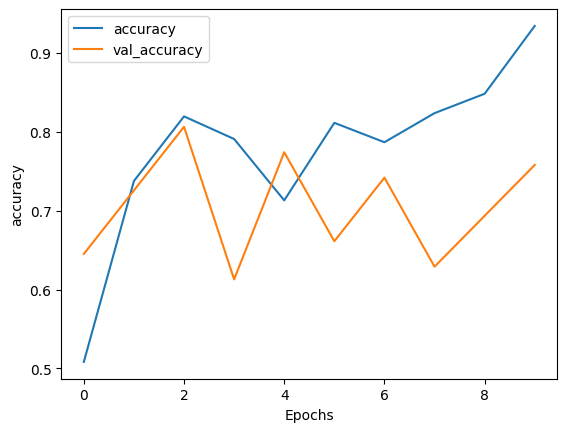

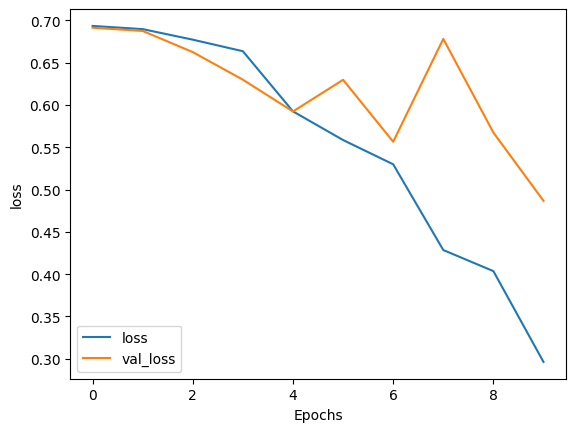

In [ ]:
# plot graph of accuracy and loss over time
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
#save the model
model_bilstm.save('bilstm_10.h5')


## another set of epochs

Epoch 1/50
8/8 - 7s - 821ms/step - accuracy: 0.9344 - loss: 0.1982 - val_accuracy: 0.7097 - val_loss: 0.5133
Epoch 2/50
8/8 - 6s - 708ms/step - accuracy: 0.9590 - loss: 0.1732 - val_accuracy: 0.7581 - val_loss: 0.4687
Epoch 3/50
8/8 - 6s - 700ms/step - accuracy: 0.9836 - loss: 0.1025 - val_accuracy: 0.8548 - val_loss: 0.3333
Epoch 4/50
8/8 - 6s - 720ms/step - accuracy: 0.9918 - loss: 0.0556 - val_accuracy: 0.8871 - val_loss: 0.3522
Epoch 5/50
8/8 - 6s - 738ms/step - accuracy: 0.9959 - loss: 0.0418 - val_accuracy: 0.8710 - val_loss: 0.3915
Epoch 6/50
8/8 - 6s - 693ms/step - accuracy: 1.0000 - loss: 0.0371 - val_accuracy: 0.9032 - val_loss: 0.3708
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.8938 - loss: 0.4013
8/8 - 2s - 242ms/step - accuracy: 0.9918 - loss: 0.0319
2/2 - 0s - 233ms/step - accuracy: 0.9032 - loss: 0.3708
Train accuracy: 99.18
Valid accuracy: 90.32


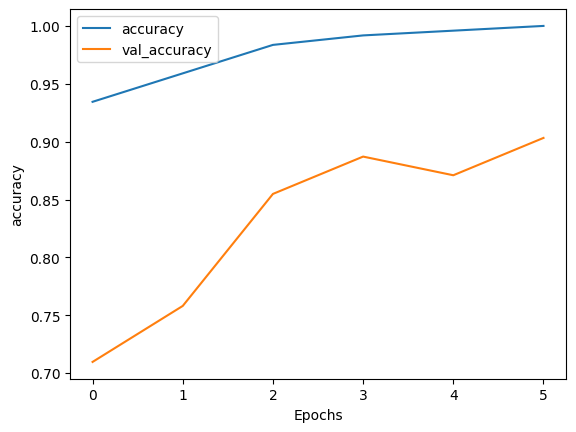

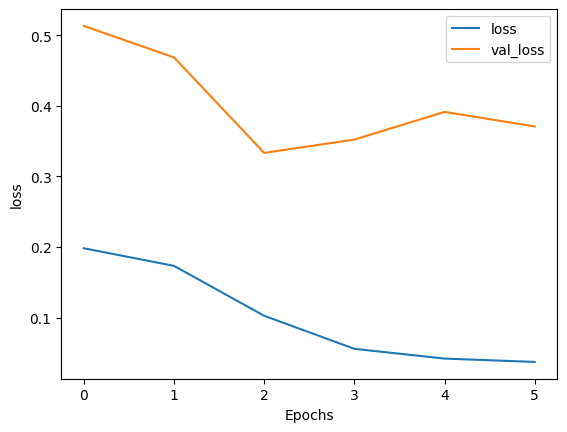

In [ ]:
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history2 = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

model_bilstm.evaluate(testing_padded, y_test)

training_padded = np.array(training_padded, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

testing_padded = np.array(testing_padded, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

training_bil_results2 = model_bilstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=32)
valid_bil_results2 = model_bilstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=32)

print(f'Train accuracy: {training_bil_results2[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bil_results2[1]*100:0.2f}')

# plot graph of accuracy and loss over time
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

model_bilstm.save('bilstm_50.h5')

Epoch 1/100
8/8 - 6s - 701ms/step - accuracy: 0.9959 - loss: 0.0348 - val_accuracy: 0.9355 - val_loss: 0.2466
Epoch 2/100
8/8 - 6s - 689ms/step - accuracy: 0.9877 - loss: 0.0371 - val_accuracy: 0.8871 - val_loss: 0.3564
Epoch 3/100
8/8 - 6s - 792ms/step - accuracy: 0.9959 - loss: 0.0176 - val_accuracy: 0.8548 - val_loss: 0.3620
Epoch 4/100
8/8 - 7s - 827ms/step - accuracy: 0.9877 - loss: 0.0332 - val_accuracy: 0.8065 - val_loss: 0.4605
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.8085 - loss: 0.4824
8/8 - 2s - 262ms/step - accuracy: 0.9959 - loss: 0.0290
2/2 - 1s - 268ms/step - accuracy: 0.8065 - loss: 0.4605
Train accuracy: 99.59
Valid accuracy: 80.65


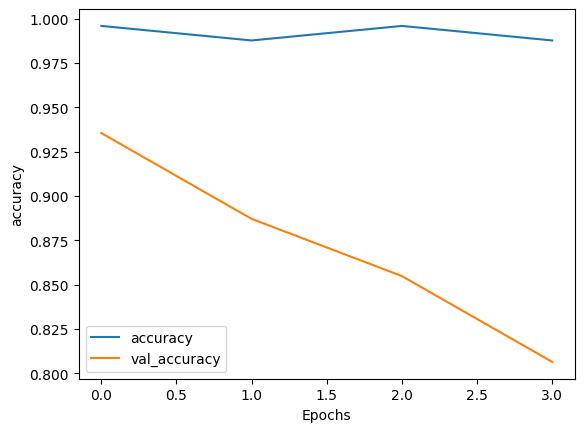

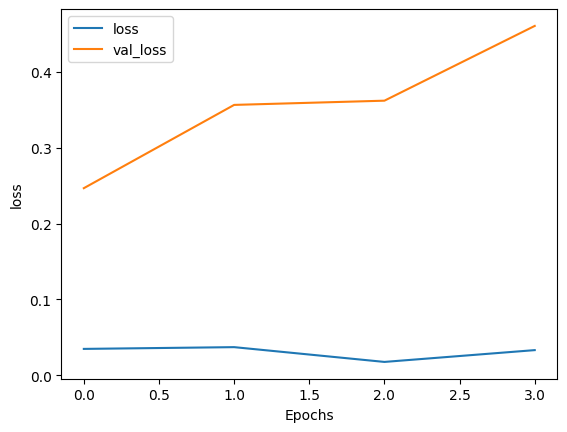

In [ ]:
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history2 = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

model_bilstm.evaluate(testing_padded, y_test)

training_padded = np.array(training_padded, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

testing_padded = np.array(testing_padded, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

training_bil_results2 = model_bilstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=32)
valid_bil_results2 = model_bilstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=32)

print(f'Train accuracy: {training_bil_results2[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bil_results2[1]*100:0.2f}')

# plot graph of accuracy and loss over time
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

model_bilstm.save('bilstm_100.h5')

Epoch 1/1000
8/8 - 6s - 812ms/step - accuracy: 0.9918 - loss: 0.0633 - val_accuracy: 0.7419 - val_loss: 0.6235
Epoch 2/1000
8/8 - 6s - 787ms/step - accuracy: 0.9795 - loss: 0.0564 - val_accuracy: 0.8871 - val_loss: 0.3186
Epoch 3/1000
8/8 - 7s - 831ms/step - accuracy: 0.9918 - loss: 0.0428 - val_accuracy: 0.9355 - val_loss: 0.2248
Epoch 4/1000
8/8 - 7s - 834ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.9194 - val_loss: 0.2669
Epoch 5/1000
8/8 - 7s - 876ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8871 - val_loss: 0.3399
Epoch 6/1000
8/8 - 7s - 913ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9032 - val_loss: 0.3069
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.8938 - loss: 0.3406
8/8 - 2s - 277ms/step - accuracy: 1.0000 - loss: 0.0054
2/2 - 1s - 274ms/step - accuracy: 0.9032 - loss: 0.3069
Train accuracy: 100.00
Valid accuracy: 90.32


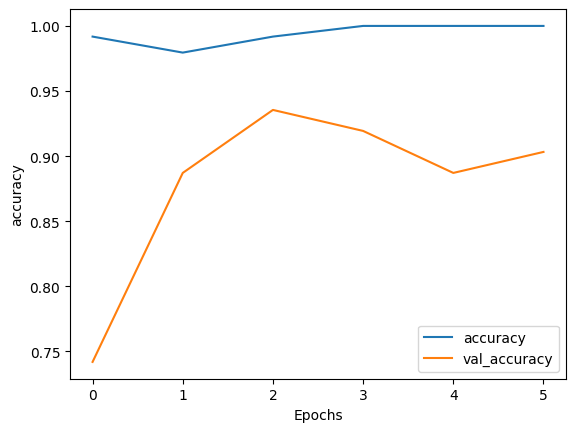

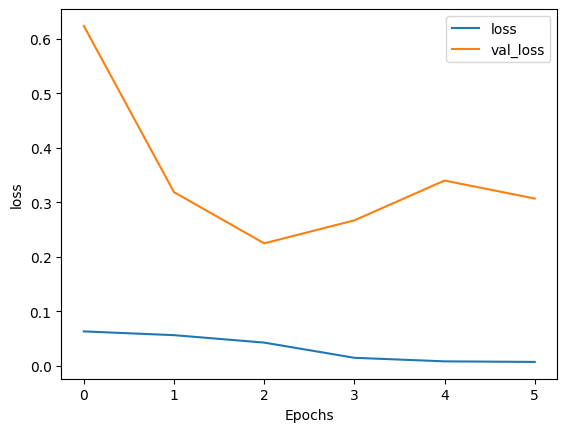

In [ ]:
num_epochs = 1000
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history2 = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

model_bilstm.evaluate(testing_padded, y_test)

training_padded = np.array(training_padded, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

testing_padded = np.array(testing_padded, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

training_bil_results2 = model_bilstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=32)
valid_bil_results2 = model_bilstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=32)

print(f'Train accuracy: {training_bil_results2[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bil_results2[1]*100:0.2f}')

# plot graph of accuracy and loss over time
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')
model_bilstm.save('bilstm_1k.h5')